#  Neurogenomics Project 3: Gills


In [1]:
!pip install Bio
!pip install pysam

import pysam
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq, translate
from scipy.stats import binom
from collections import Counter
from itertools import permutations
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 70.6 MB/s eta 0:00:00


In [2]:
# Set working directory
working_dir = "/kaggle/working/"
# Set data directory
data_dir = "/kaggle/input/squidrna/"

# Import bam file
gfl_bam = pysam.AlignmentFile(data_dir + "gill.bam", "rb")

[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai


## Read the transcriptome file and collect gene id's, open reading frame and the RNA sequence of each gene

In [3]:
# Initialise empty lists
ids = []
sequences = []
orf_starts = []
orf_ends = []

# Create a text file with genes id's
with open(working_dir + "genes.txt", "w") as results:  

    # Iterate over every entry in fasta file using SeqIO module
    for seq in SeqIO.parse(data_dir + "pealeii.fasta", "fasta"):
            
        # Write gene ID in file
        results.write(seq.id + "\n")
    
        # Collect gene ID
        ids.append(seq.id)
        # Collect sequence
        sequences.append(seq.seq)
    
        # Divide sequence description by tab characters 
        desc = seq.description.split("\t") 
        
        # Collect ORF starting position
        orf_starts.append(desc[2])
        # Collect ORF ending position
        orf_ends.append(desc[4])

# Combine gene IDs, ORF positions and sequences into a dataframe
df = pd.DataFrame({"id": ids, "start": orf_starts, "end": orf_ends, "seq": sequences})

# Convert ORF positions to integers
df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

# RNA editing analysis

In [4]:
# Base options
letters = "ACTG"
# Quality score 30 corresponds to 1/1000 error rate, or 1e-3 sequencing error
min_base_quality = 30
# Propability of sequencing error given qaulity score of 30
error_rate = 1e-3
# The maximal mapping quality means unique alignment, with bowtie2 this number is 42
min_mapping_quality = 42
# The cutoff for significance
alpha = 0.05

# A dictionary for positions (keys) and sequences (values) 
position_dict = {}
# A list for mutations count
pair_counter = Counter({"".join(pair): 0 for pair in permutations(letters, 2)})
# Reference seqences
ref_seq_list = []
# Variant seqences
var_seq_list = []
# Significant results
signif_list = []
# Genes positions
pos_list = []

# In order to allow a normative running time for testing the code, we will only run on
# a subset of 3000 genes from the list of genes we created at the beginning of the code
x, X = 0, 3000

In [5]:
# The function calculates how many counts are there for each base.
# It gets a dict of sequences and their places and the optional bases
# and returns a list of proportions that represent the relative frequency
# of the base in the different positions 
def count_matches(positions: dict, letter: str):
    
    # Positions - a dictionary containes places on the DNA and there values
    # Letter - ATCG
    
    # Dictionary size - determines our range for seq amount
    read_range = range(max(positions.keys()) + 1)
    
    # For each seq, check how many times the letter exists
    matches = [positions.get(i, "").count(letter) for i in read_range]
    # What are the proportions for each letter from the total reads
    matches = list(map(lambda x: x / sum(matches), matches))
    
    return matches

In [6]:
# Write into modifications file
with open(working_dir + "modifications.txt", "w") as results:
    
    results.write("Gene\tPosition\tCoverage\tA\tC\tT\tG\tVar\tTotal\tPadj\n")

    for transcript_name in df["id"]: # Run on 1000 genes only, then stop
        
        if x == X:
            break
        x += 1
        
        # Find the relevant position of the gene and its ORF
        transcript = df[df["id"] == transcript_name].reset_index()  
        orf_start = transcript["start"][0]
        orf_end = transcript["end"][0]
        orf_range = orf_end - orf_start
        
        # Initialise lists for sequences, significance and positions
        ref_seq, var_seq = Seq(""), Seq("")
        signif = []
        gene_pos = []

        # Generate pileup for one gene, using bam file
        gene_pileup = gfl_bam.pileup(
            transcript_name,
            start=orf_start,
            stop=orf_end,
            min_base_quality=min_base_quality,
            min_mapping_quality=min_mapping_quality
        )
            
        # For each column in one pileup
        for column in gene_pileup:

            # Initialise base counter
            base_counter = Counter({base: 0 for base in letters})

            # For each read
            for read in column.pileups:
                # Continue as long as read is valid
                if not read.is_del and not read.is_refskip:

                    # Store read position
                    read_pos = read.query_position
                    # Store base
                    base = read.alignment.query_sequence[read_pos]

                    # Add 1 count of found base to counter
                    base_counter.update(base)
                    # Store base from all reads
                    position_dict[read_pos] = position_dict.get(read_pos, "") + base

            # Find reference and variant bases
            ref, var = base_counter.most_common(2)
            # Compute p-value
            pval = binom.cdf(ref[1], ref[1] + var[1], 1 - error_rate)

            # Catch results for amino acid analysis
            gene_pos.append(f"{column.pos}:{column.n}")
            ref_seq += ref[0]
            var_seq += var[0]
            signif.append(pval < alpha / orf_range)

            if signif[-1]: # If results are significant

                # Add 1 count for detected ref/var pair
                pair_counter.update({ref[0] + var[0]: 1})

                # Count matches of reference across all reads
                matches = count_matches(position_dict, ref[0])
                # Count matches of variant across all reads
                mismatches = count_matches(position_dict, var[0])

                results.write(f"{transcript_name}\t")
                results.write(f"{column.pos}\t{column.n}\t")
                results.write(f"{base_counter['A']}\t{base_counter['C']}\t")
                results.write(f"{base_counter['T']}\t{base_counter['G']}\t")
                results.write(f"{var[1]}\t{ref[1] + var[1]}\t{pval:.2g}\n")
        
        ref_seq_list.append(ref_seq)
        var_seq_list.append(var_seq)
        signif_list.append(signif)
        pos_list.append(gene_pos)

[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_idx_load3] The index file is older than the data file: /kaggle/input/squidrna/gill.bam.bai
[W::hts_id

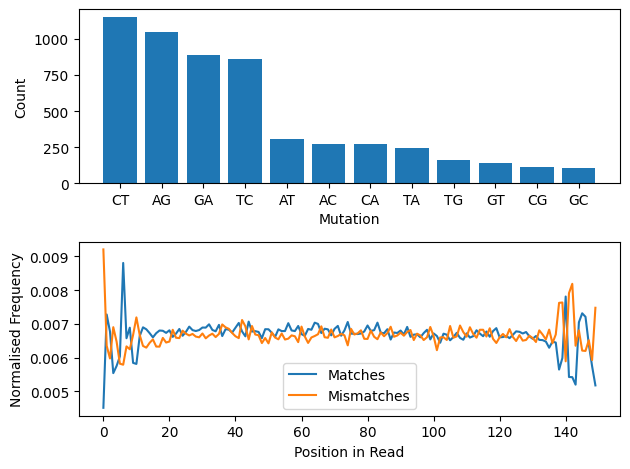

In [7]:
# Sort mutation pairs by count
pair_counter = dict(sorted(pair_counter.items(), key=lambda item: item[1], reverse=True))

fig, axes = plt.subplots(2)

# Visualise barplot of mutation pairs
axes[0].bar(pair_counter.keys(), pair_counter.values())
axes[0].set_xlabel("Mutation")
axes[0].set_ylabel("Count")

# Visualise lineplot of matches and mismatches within a read
axes[1].plot(matches, label="Matches")
axes[1].plot(mismatches, label="Mismatches")

axes[1].set_xlabel("Position in Read")
axes[1].set_ylabel("Normalised Frequency")
axes[1].legend(loc="lower center")

plt.tight_layout()

# Amino acid mudifications analysis

In [8]:
# Initialise amino acid modifications counter
aa_counter = Counter()

# Find amino-acid modifications
# Write results in a file
with open(working_dir + "aminoacids.txt", "w") as results:
    
    results.write("Gene\tPosition\tCodonPosition\tRefSeq\tVarSeq\tRefAA\tVarAA\n")
    
    # For each gene
    for i in range(len(pos_list)):
        
        gene_pos = pos_list[i]
        signif = signif_list[i]
        ref_seq = ref_seq_list[i]
        var_seq = var_seq_list[i]
        
        # For each position
        for pos in range(len(gene_pos)): 
            if signif[pos]:
                
                results.write(f"{i}\t")

                # Infer position in codon [0, 1, 2]
                codon_idx = pos % 3
                results.write(f"{gene_pos[pos]}\t{codon_idx}\t")

                # Extract codon from reference sequence
                subseq = ref_seq[pos - codon_idx:pos + 3 - codon_idx]
                
                # Translate reference codon to amino acid
                ref_aa = translate(subseq)
                results.write(f"{subseq}\t{ref_aa}\t")

                # Convert reference to variant sequence
                subseq = list(subseq)
                subseq[codon_idx] = var_seq[pos]
                subseq = "".join(subseq)

                # Translate variant codon to aminoacid
                var_aa = translate(subseq)
                results.write(f"{subseq}\t{var_aa}\n")

                if ref_aa == var_aa:
                    # Add 1 count to synonymous modification
                    aa_counter.update({"synonymous": 1})
                else:
                    # Add 1 count to found modification
                    aa_counter.update({str(ref_aa) + str(var_aa): 1})

<Axes: ylabel='Modification'>

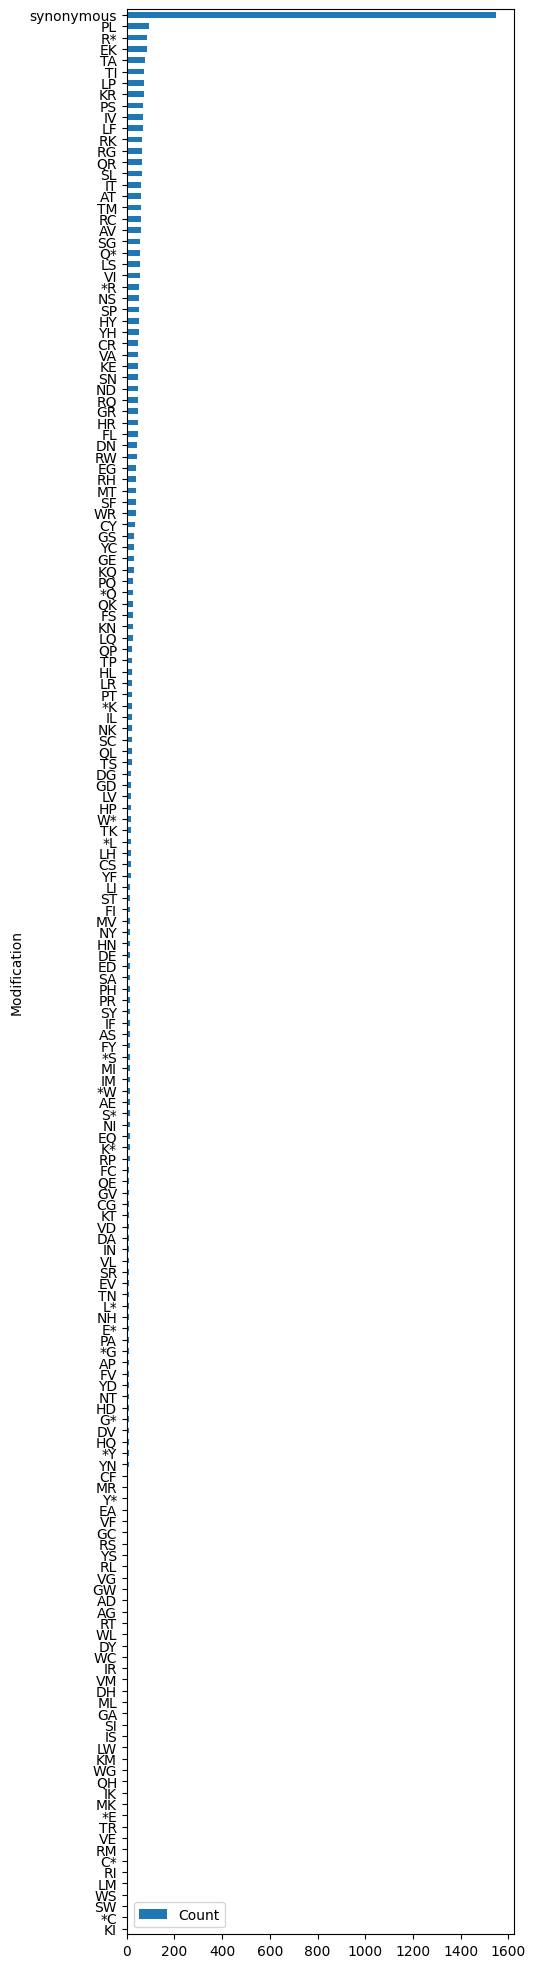

In [9]:
# Visualise amino acid mudifications

aa_df = pd.DataFrame.from_dict(aa_counter, orient="index").reset_index()
aa_df.columns = ["Modification", "Count"]
aa_df.sort_values("Count",inplace=True)

aa_df.plot(kind="barh", y="Count", x="Modification", figsize=(5, 25))